In [47]:
import os
import json
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import r2_score
from pyproj import Transformer
from tqdm import tqdm
import pickle

In [48]:
# 获取当前日期
def get_dtime():
    # 例如20240516
    import datetime
    dtime = datetime.datetime.now().strftime('%Y%m%d')
    return dtime

In [49]:
# 导入autogluon模型
model_path = r"F:\cache_data\zone_ana\dy\modle\autogluon_type_class_DY_20240726"

In [50]:
# 砂岩
sy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'sy'),'sdt'))
sy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'sy'),'fzrt'))
sy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'sy'),'zrt'))
# 碳酸岩
tsy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'tsy'),'sdt'))
tsy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'tsy'),'fzrt'))
tsy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'tsy'),'zrt'))
# 第四系红粘土
hnt_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hnt'),'sdt'))
hnt_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hnt'),'fzrt'))
hnt_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hnt'),'zrt'))
# 泥页岩
nyy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'nyy'),'sdt'))
nyy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'nyy'),'fzrt'))
nyy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'nyy'),'zrt'))
# 紫红色砂页岩
zhsyy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'zhsyy'),'sdt'))
zhsyy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'zhsyy'),'fzrt'))
zhsyy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'zhsyy'),'zrt'))
# 河流冲积物
hlcjw_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hlcjw'),'sdt'))
# 砾岩
ly_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'ly'),'sdt'))
ly_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'ly'),'fzrt'))
ly_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'ly'),'zrt'))
# 第四纪冰川冲积物
bccjw_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'bccjw'),'sdt'))
bccjw_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'bccjw'),'fzrt'))
bccjw_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'bccjw'),'zrt'))
# 砂页岩
syy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'syy'),'sdt'))
syy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'syy'),'fzrt'))
syy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'syy'),'zrt'))

In [51]:
# 获取特征函数

def get_feature_names(predictor):
    feature_names = predictor.feature_metadata_in.get_features()
    return feature_names
sdt_feature_names = syy_sdt_predictor.feature_metadata_in.get_features()
print("SDT",sdt_feature_names)
fzrt_feature_names = syy_fzrt_predictor.feature_metadata_in.get_features()
print("FZRT",fzrt_feature_names)
zrt_feature_names = syy_zrt_predictor.feature_metadata_in.get_features()
print("ZRT",zrt_feature_names)

SDT ['Centroid_X', 'Centroid_Y', 'DEM_RANGE', 'DEM_MEAN', 'DEM_STD', 'AnalyticalHillshading_MEAN', 'Aspect_MEAN', 'ChannelNetworkBaseLevel_MEAN', 'ChannelNetworkDistance_MEAN', 'ConvergenceIndex_MEAN', 'LSFactor_MEAN', 'MRRTF_MEAN', 'MRVBF_MEAN', 'PlanCurvature_MEAN', 'ProfileCurvature_MEAN', 'RelativeSlopePosition_MEAN', 'Slope_MEAN', 'TopographicWetnessIndex_MEAN', 'TotalCatchmentArea_MEAN', 'ValleyDepth_MEAN', 'NIGHT2022_MEAN', 'ETP2022_mean_MEAN', 'TMP2022_mean_MEAN', 'PRE2022_mean_MEAN', 'PRE2022_3_MEAN', 'PRE2022_11_MEAN', 'ETP2022_3_MEAN', 'ETP2022_11_MEAN', 'TMP2022_3_MEAN', 'TMP2022_11_MEAN', 'evi_MEAN', 'lswi_MEAN', 'mndwi_MEAN', 'ndvi_MEAN', 'ndwi_MEAN', 'PCA_0_MEAN', 'PCA_1_MEAN', 'savi_MEAN', 'vari_MEAN', 'SlopeClass_MAJORITY']
FZRT ['DLMC', 'Centroid_X', 'Centroid_Y', 'DEM_RANGE', 'DEM_MEAN', 'DEM_STD', 'AnalyticalHillshading_MEAN', 'Aspect_MEAN', 'ChannelNetworkBaseLevel_MEAN', 'ChannelNetworkDistance_MEAN', 'ConvergenceIndex_MEAN', 'LSFactor_MEAN', 'MRRTF_MEAN', 'MRVBF_

In [52]:
# 存放预测结果的路径
result_path =  r"F:\cache_data\zone_ana\dy\prediction_result"

In [53]:
# 读取数据集
feature_path = r'F:\cache_data\zone_ana\dy\prediction_data\result_20240728.csv'

In [54]:
feature_df = pd.read_csv(feature_path)

In [55]:
feature_df.columns

Index(['OBJECTID', 'DLMC', '母质', 'gridcode', 'XMin', 'YMin', 'XMax', 'YMax',
       'Centroid_X', 'Centroid_Y',
       ...
       'DZ_MAX', 'DZ_RANGE', 'DZ_MEAN', 'DZ_STD', 'DZ_SUM', 'DZ_VARIETY',
       'DZ_MAJORITY', 'DZ_MINORITY', 'DZ_MEDIAN', 'DZ_PCT90'],
      dtype='object', length=400)

In [56]:
rows_with_nan = feature_df.loc[feature_df.isnull().any(axis=1)]
rows_with_nan

,OBJECTID,DLMC,母质,gridcode,XMin,YMin,XMax,YMax,Centroid_X,Centroid_Y,...,DZ_MAX,DZ_RANGE,DZ_MEAN,DZ_STD,DZ_SUM,DZ_VARIETY,DZ_MAJORITY,DZ_MINORITY,DZ_MEDIAN,DZ_PCT90


In [57]:
# 选择数值类型的列
numeric_cols = feature_df.select_dtypes(include=[np.float64])

# 计算数值列的均值
mean_values = numeric_cols.mean()

# 用均值填充数值列的空值
feature_df[numeric_cols.columns] = numeric_cols.fillna(mean_values)

In [58]:
rows_with_nan = feature_df.loc[feature_df.isnull().any(axis=1)]
rows_with_nan

,OBJECTID,DLMC,母质,gridcode,XMin,YMin,XMax,YMax,Centroid_X,Centroid_Y,...,DZ_MAX,DZ_RANGE,DZ_MEAN,DZ_STD,DZ_SUM,DZ_VARIETY,DZ_MAJORITY,DZ_MINORITY,DZ_MEDIAN,DZ_PCT90


In [59]:
feature_df.rename(columns={'母质':'MZ'},inplace=True)

In [60]:
dataset = feature_df

In [61]:
dataset.columns

Index(['OBJECTID', 'DLMC', 'MZ', 'gridcode', 'XMin', 'YMin', 'XMax', 'YMax',
       'Centroid_X', 'Centroid_Y',
       ...
       'DZ_MAX', 'DZ_RANGE', 'DZ_MEAN', 'DZ_STD', 'DZ_SUM', 'DZ_VARIETY',
       'DZ_MAJORITY', 'DZ_MINORITY', 'DZ_MEDIAN', 'DZ_PCT90'],
      dtype='object', length=400)

In [62]:

duplicated_rows = dataset[dataset['OBJECTID'].duplicated(keep=False)]

In [63]:
duplicated_rows

,OBJECTID,DLMC,MZ,gridcode,XMin,YMin,XMax,YMax,Centroid_X,Centroid_Y,...,DZ_MAX,DZ_RANGE,DZ_MEAN,DZ_STD,DZ_SUM,DZ_VARIETY,DZ_MAJORITY,DZ_MINORITY,DZ_MEDIAN,DZ_PCT90


In [65]:
# 统计总数据中各个岩石类型的总数
value_counts_dict = dataset['MZ'].value_counts().to_dict()


In [66]:
# 筛选砂岩水稻土数据
sy_sdt_data = dataset[dataset['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                      & (dataset['MZ'] == '砂岩')]
# 筛砂岩选非自然土数据
sy_fzrt_data = dataset[~dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                       & (dataset['MZ'] == '砂岩')]
# 筛选自然土数据
sy_zrt_data = dataset[dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地'])
                   & (dataset['MZ'] == '砂岩')]
print(sy_sdt_data.shape[0]+sy_fzrt_data.shape[0]+sy_zrt_data.shape[0],value_counts_dict['砂岩'])

54613 54613


In [67]:
# 筛选碳酸岩水稻土数据
tsy_sdt_data = dataset[dataset['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                      & (dataset['MZ'] == '碳酸岩')]

# 筛选碳酸岩选非自然土数据
tsy_fzrt_data = dataset[~dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                        &(dataset['MZ'] == '碳酸岩')]

# 筛选碳酸岩自然土数据
tsy_zrt_data = dataset[dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地'])
                   & (dataset['MZ'] == '碳酸岩')]
print(tsy_sdt_data.shape[0]+tsy_fzrt_data.shape[0]+tsy_zrt_data.shape[0],value_counts_dict['碳酸岩'])

64903 64903


In [68]:
# 筛选第四系红粘土水稻土数据
hnt_sdt_data = dataset[dataset['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                      & (dataset['MZ'] == '第四系红粘土')]

# 筛选第四系红粘土非自然土数据
hnt_fzrt_data = dataset[~dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                       & (dataset['MZ'] == '第四系红粘土')]

# 筛选第四系红粘土自然土数据
hnt_zrt_data = dataset[dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地'])
                   & (dataset['MZ'] == '第四系红粘土')]
print(hnt_sdt_data.shape[0]+hnt_fzrt_data.shape[0]+hnt_zrt_data.shape[0],value_counts_dict['第四系红粘土'])

39925 39925


In [69]:
# 筛选泥(页)岩水稻土数据
nyy_sdt_data = dataset[dataset['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                      & (dataset['MZ'] == '泥(页)岩')]

# 筛选泥(页)岩非自然土数据
nyy_fzrt_data = dataset[~dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                       & (dataset['MZ'] == '泥(页)岩')]

# 筛选泥(页)岩自然土数据
nyy_zrt_data = dataset[dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地'])
                   & (dataset['MZ'] == '泥(页)岩')]
print(nyy_sdt_data.shape[0]+nyy_fzrt_data.shape[0]+nyy_zrt_data.shape[0],value_counts_dict['泥(页)岩'])

50440 50440


In [70]:
# 筛选紫红色砂页岩水稻土数据
zhsyy_sdt_data = dataset[dataset['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                      &(dataset['MZ'] == '紫红色砂页岩')]

# 筛选紫红色砂页岩非自然土数据
zhsyy_fzrt_data = dataset[~dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                       & (dataset['MZ'] == '紫红色砂页岩')]

# 筛选紫红色砂页岩自然土数据
zhsyy_zrt_data = dataset[dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地'])
                   & (dataset['MZ'] == '紫红色砂页岩')]
print(zhsyy_sdt_data.shape[0]+zhsyy_fzrt_data.shape[0]+zhsyy_zrt_data.shape[0],value_counts_dict['紫红色砂页岩'])

370 370


In [71]:
# 筛选河流冲积物水稻土数据
hlcjw_sdt_data = dataset[(dataset['MZ'] == '河流冲积物')]
print(hlcjw_sdt_data.shape[0],value_counts_dict['河流冲积物'])

4854 4854


In [72]:
# 筛选砾岩水稻土数据
ly_sdt_data = dataset[dataset['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                      & (dataset['MZ'] == '砾岩')]

# 筛选砾岩非自然土数据
ly_fzrt_data = dataset[~dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                       & (dataset['MZ'] == '砾岩')]

# 筛选砾岩非自然土数据
ly_zrt_data = dataset[dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地']) 
                       & (dataset['MZ'] == '砾岩')]
print(ly_sdt_data.shape[0]+ly_fzrt_data.shape[0]+ly_zrt_data.shape[0],value_counts_dict['砾岩'])

965 965


In [73]:
# 筛选第四纪冰川冲积物水稻土数据
bccjw_sdt_data = dataset[dataset['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                     & (dataset['MZ'] == '第四纪冰川冲积物')]

# 筛选第四纪冰川冲积物非自然土数据
bccjw_fzrt_data = dataset[~dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                       & (dataset['MZ'] == '第四纪冰川冲积物')]

# 筛选第四纪冰川冲积物自然土数据
bccjw_zrt_data = dataset[dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地'])
                   & (dataset['MZ'] == '第四纪冰川冲积物')]
print(bccjw_sdt_data.shape[0]+bccjw_fzrt_data.shape[0]+bccjw_zrt_data.shape[0],value_counts_dict['第四纪冰川冲积物'])

104 104


In [74]:
# 筛选砂页岩水稻土数据
syy_sdt_data = dataset[dataset['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                      & (dataset['MZ'] == '砂页岩')]

# 筛选砂页岩非自然土数据
syy_fzrt_data = dataset[~dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                       & (dataset['MZ'] == '砂页岩')]

# 筛选砂页岩物自然土数据
syy_zrt_data = dataset[dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地'])
                   & (dataset['MZ'] == '砂页岩')]
print(syy_sdt_data.shape[0]+syy_fzrt_data.shape[0]+syy_zrt_data.shape[0],value_counts_dict['砂页岩'])

567 567


In [75]:
# 查看各个数据集的大小
print('砂岩',sy_sdt_data.shape,sy_fzrt_data.shape,sy_zrt_data.shape)
print('碳酸岩',tsy_sdt_data.shape,tsy_fzrt_data.shape,tsy_zrt_data.shape)
print('第四系红粘土',hnt_sdt_data.shape,hnt_fzrt_data.shape,hnt_zrt_data.shape)
print('泥页岩',nyy_sdt_data.shape,nyy_fzrt_data.shape,nyy_zrt_data.shape)
print('紫红色砂页岩',zhsyy_sdt_data.shape,zhsyy_fzrt_data.shape,zhsyy_zrt_data.shape)
print('河流冲积物',hlcjw_sdt_data.shape)
print('砾岩',ly_sdt_data.shape,ly_fzrt_data.shape,ly_zrt_data.shape)
print('第四纪冰川冲积物',bccjw_sdt_data.shape,bccjw_fzrt_data.shape,bccjw_zrt_data.shape)
print('砂页岩',syy_sdt_data.shape,syy_fzrt_data.shape,syy_zrt_data.shape)



砂岩 (9599, 400) (18691, 400) (26323, 400)
碳酸岩 (8590, 400) (26866, 400) (29447, 400)
第四系红粘土 (5802, 400) (18914, 400) (15209, 400)
泥页岩 (7980, 400) (22225, 400) (20235, 400)
紫红色砂页岩 (34, 400) (169, 400) (167, 400)
河流冲积物 (4854, 400)
砾岩 (65, 400) (453, 400) (447, 400)
第四纪冰川冲积物 (3, 400) (33, 400) (68, 400)
砂页岩 (26, 400) (340, 400) (201, 400)


In [76]:
# 获取对照字典
with open(r'D:\worker_code\Terrain_Test\data\soil_dict_20240726.json', 'r') as f:
    soil_dict = json.load(f)
# 将键转为int
soil_dict = {int(k):v for k, v in soil_dict.items()}

In [79]:
zhsyy_sdt_predictor.model_names()

['NeuralNetFastAI',
 'RandomForestGini',
 'RandomForestEntr',
 'ExtraTreesGini',
 'ExtraTreesEntr',
 'NeuralNetTorch',
 'WeightedEnsemble_L2']

In [106]:
# 模型选择
# select_model = 'WeightedEnsemble_L2'
select_model = 'RandomForestEntr'

In [107]:
# 概率预测函数
def predict_top_classes(data, predictor,feature_names, model, top_n, soil_dict):
    """
    根据给定的AutoGluon模型，预测数据集中的前n个最可能的类别及其概率，并根据提供的字典转换类别编号为描述字符串。
    参数:
    data (DataFrame): 输入的数据集。
    predictor（model）: 对应的模型
    feature_names (list): 用于预测的特征名列表。
    model (str): 选择的模型名称。
    top_n (int): 需要返回的最高概率的类别数量。
    soil_dict (dict): 类别编号到描述字符串的映射字典。
    
    返回:
    DataFrame: 原始数据与预测结果合并后的DataFrame。
    """
    # 复制数据
    data = data.copy()
    # 预测概率
    pred_probs = predictor.predict_proba(data[feature_names], model=model)
    # 获取概率最高的前n个类别及其概率
    top_classes = pred_probs.apply(lambda x: pd.Series(x.nlargest(top_n).index.astype(int).tolist() + x.nlargest(top_n).values.tolist()), axis=1)
    # 重命名列
    class_cols = ['Class{}'.format(i+1) for i in range(top_n)]
    prob_cols = ['Prob{}'.format(i+1) for i in range(top_n)]
    top_classes.columns = class_cols + prob_cols
    # 转换类别编号为描述字符串
    for col in class_cols:
        top_classes[col] = top_classes[col].map(soil_dict)
    # 计算每个预测的熵
    entropy = pred_probs.apply(lambda x: -np.sum(x * np.log(x + 1e-9)), axis=1)
    top_classes['Entropy'] = entropy
    # 计算每个预测的不确定性（标准差）
    uncertainty = pred_probs.std(axis=1)
    top_classes['Uncertainty'] = uncertainty
    # 将新列添加到原有的DataFrame中
    return pd.concat([data, top_classes], axis=1)

In [108]:
# 模型预测
sy_sdt_result_df = predict_top_classes(sy_sdt_data, sy_sdt_predictor,get_feature_names(sy_sdt_predictor), select_model, 2, soil_dict)
sy_fzrt_result_df = predict_top_classes(sy_fzrt_data, sy_fzrt_predictor,get_feature_names(sy_fzrt_predictor), select_model, 2, soil_dict)
sy_zrt_result_df = predict_top_classes(sy_zrt_data, sy_zrt_predictor,get_feature_names(sy_zrt_predictor), select_model, 2, soil_dict)

tsy_sdt_result_df = predict_top_classes(tsy_sdt_data, tsy_sdt_predictor,get_feature_names(tsy_sdt_predictor), select_model, 2, soil_dict)
tsy_fzrt_result_df = predict_top_classes(tsy_fzrt_data, tsy_fzrt_predictor,get_feature_names(tsy_fzrt_predictor), select_model, 2, soil_dict)
tsy_zrt_result_df = predict_top_classes(tsy_zrt_data, tsy_zrt_predictor,get_feature_names(tsy_zrt_predictor), select_model, 2, soil_dict)

hnt_sdt_result_df = predict_top_classes(hnt_sdt_data, hnt_sdt_predictor,get_feature_names(hnt_sdt_predictor), select_model, 2, soil_dict)
hnt_fzrt_result_df = predict_top_classes(hnt_fzrt_data, hnt_fzrt_predictor,get_feature_names(hnt_fzrt_predictor), select_model, 2, soil_dict)
hnt_zrt_result_df = predict_top_classes(hnt_zrt_data, hnt_zrt_predictor,get_feature_names(hnt_zrt_predictor), select_model, 2, soil_dict)

nyy_sdt_result_df = predict_top_classes(nyy_sdt_data, nyy_sdt_predictor,get_feature_names(nyy_sdt_predictor), select_model, 2, soil_dict)
nyy_fzrt_result_df = predict_top_classes(nyy_fzrt_data, nyy_fzrt_predictor,get_feature_names(nyy_fzrt_predictor), select_model, 2, soil_dict)
nyy_zrt_result_df = predict_top_classes(nyy_zrt_data, nyy_zrt_predictor,get_feature_names(nyy_zrt_predictor), select_model, 2, soil_dict)

zhsyy_sdt_result_df = predict_top_classes(zhsyy_sdt_data, zhsyy_sdt_predictor,get_feature_names(zhsyy_sdt_predictor), select_model, 2, soil_dict)
zhsyy_fzrt_result_df = predict_top_classes(zhsyy_fzrt_data, zhsyy_fzrt_predictor,get_feature_names(zhsyy_fzrt_predictor), select_model, 2, soil_dict)
zhsyy_zrt_result_df = predict_top_classes(zhsyy_zrt_data, zhsyy_zrt_predictor,get_feature_names(zhsyy_zrt_predictor), select_model, 2, soil_dict)

hlcjw_sdt_result_df = predict_top_classes(hlcjw_sdt_data, hlcjw_sdt_predictor,get_feature_names(hlcjw_sdt_predictor), select_model, 2, soil_dict)


ly_sdt_result_df = predict_top_classes(ly_sdt_data, ly_sdt_predictor,get_feature_names(ly_sdt_predictor), select_model, 2, soil_dict)
ly_fzrt_result_df = predict_top_classes(ly_fzrt_data, ly_fzrt_predictor,get_feature_names(ly_fzrt_predictor), select_model, 2, soil_dict)
ly_zrt_result_df = predict_top_classes(ly_zrt_data, ly_zrt_predictor,get_feature_names(ly_zrt_predictor), select_model, 2, soil_dict)

bccjw_sdt_result_df = predict_top_classes(bccjw_sdt_data, bccjw_sdt_predictor,get_feature_names(bccjw_sdt_predictor), select_model, 2, soil_dict)
bccjw_fzrt_result_df = predict_top_classes(bccjw_fzrt_data, bccjw_fzrt_predictor,get_feature_names(bccjw_fzrt_predictor), select_model, 2, soil_dict)
bccjw_zrt_result_df = predict_top_classes(bccjw_zrt_data, bccjw_zrt_predictor,get_feature_names(bccjw_zrt_predictor), select_model, 2, soil_dict)

syy_sdt_result_df = predict_top_classes(syy_sdt_data, syy_sdt_predictor,get_feature_names(syy_sdt_predictor), select_model, 2, soil_dict)
syy_fzrt_result_df = predict_top_classes(syy_fzrt_data, syy_fzrt_predictor,get_feature_names(syy_fzrt_predictor), select_model, 2, soil_dict)
syy_zrt_result_df = predict_top_classes(syy_zrt_data, syy_zrt_predictor,get_feature_names(syy_zrt_predictor), select_model, 2, soil_dict)

In [109]:
# 将所有的DataFrame放入一个列表中
dfs = [
    sy_sdt_result_df, sy_fzrt_result_df, sy_zrt_result_df,
    tsy_sdt_result_df, tsy_fzrt_result_df, tsy_zrt_result_df,
    hnt_sdt_result_df, hnt_fzrt_result_df, hnt_zrt_result_df,
    nyy_sdt_result_df, nyy_fzrt_result_df, nyy_zrt_result_df,
    zhsyy_sdt_result_df, zhsyy_fzrt_result_df, zhsyy_zrt_result_df,
    hlcjw_sdt_result_df,
    ly_sdt_result_df, ly_fzrt_result_df, ly_zrt_result_df,
    bccjw_sdt_result_df, bccjw_fzrt_result_df, bccjw_zrt_result_df,
    syy_sdt_result_df, syy_fzrt_result_df, syy_zrt_result_df
]

# 使用pd.concat合并所有的DataFrame
result_df = pd.concat(dfs, ignore_index=True)


In [110]:
result_df.columns

Index(['OBJECTID', 'DLMC', 'MZ', 'gridcode', 'XMin', 'YMin', 'XMax', 'YMax',
       'Centroid_X', 'Centroid_Y',
       ...
       'DZ_MAJORITY', 'DZ_MINORITY', 'DZ_MEDIAN', 'DZ_PCT90', 'Class1',
       'Class2', 'Prob1', 'Prob2', 'Entropy', 'Uncertainty'],
      dtype='object', length=406)

In [111]:
# 获取指定列
result_df = result_df[['OBJECTID','Class1', 'Class2', 'Prob1','Prob2', 'Entropy', 'Uncertainty']]

In [112]:
# 获取三普土种对照字典
# 读取Excel文件
sp_file_path = r"C:\Users\Runker\Desktop\dy2.xlsx"
df = pd.read_excel(sp_file_path)

# 使用前向填充（ffill）处理合并单元格的情况
df_filled = df.ffill()
# 定义一个函数来为每一行生成一个字典
def create_dict(row):
    return {
        row['TZ']: {
            '土类': row['TL'],
            '亚类': row['YL'],
            '土属': row['TS'],
        }
    }

# 使用apply方法为每一行应用这个函数，并将结果合并到一个字典中
sp_soiltype_dict = {}
for d in df_filled.apply(create_dict, axis=1):
    sp_soiltype_dict.update(d)

In [113]:
sp_soiltype_dict

{'中层泥砂质黄壤': {'土类': '黄壤', '亚类': '典型黄壤', '土属': '泥砂质黄壤'},
 '腐中层泥砂质黄壤': {'土类': '黄壤', '亚类': '典型黄壤', '土属': '泥砂质黄壤'},
 '腐薄层泥砂质黄壤': {'土类': '黄壤', '亚类': '典型黄壤', '土属': '泥砂质黄壤'},
 '黄红泥田': {'土类': '水稻土', '亚类': '潴育型水稻土', '土属': '红泥田'},
 '腐厚层红泥质黄壤': {'土类': '黄壤', '亚类': '典型黄壤', '土属': '红泥质黄壤'},
 '薄层黏质黄色石灰土': {'土类': '石灰土', '亚类': '黄色石灰土', '土属': '黏质黄色石灰土'},
 '黄渗红泥田': {'土类': '水稻土', '亚类': '渗育型水稻土', '土属': '渗红泥田'},
 '黄浅红泥田': {'土类': '水稻土', '亚类': '淹育型水稻土', '土属': '浅红泥田'},
 '潮泥田': {'土类': '水稻土', '亚类': '潴育型水稻土', '土属': '潮泥田'},
 '中层黏质黄色石灰土': {'土类': '石灰土', '亚类': '黄色石灰土', '土属': '黏质黄色石灰土'},
 '中层红泥质黄壤': {'土类': '黄壤', '亚类': '典型黄壤', '土属': '红泥质黄壤'},
 '厚层红泥质黄壤': {'土类': '黄壤', '亚类': '典型黄壤', '土属': '红泥质黄壤'},
 '腐中层黏质黄色石灰土': {'土类': '石灰土', '亚类': '黄色石灰土', '土属': '黏质黄色石灰土'},
 '腐厚层黏质黄色石灰土': {'土类': '石灰土', '亚类': '黄色石灰土', '土属': '黏质黄色石灰土'},
 '腐中层红泥质黄壤': {'土类': '黄壤', '亚类': '典型黄壤', '土属': '红泥质黄壤'},
 '厚层黏质黄色石灰土': {'土类': '石灰土', '亚类': '黄色石灰土', '土属': '黏质黄色石灰土'},
 '腐薄层黏质黄色石灰土': {'土类': '石灰土', '亚类': '黄色石灰土', '土属': '黏质黄色石灰土'},
 '腐薄层红泥质黄壤': {'土类': '黄壤', '

In [114]:
# 使用 apply 方法结合 lambda 函数来获取对应的 '土类' 值
result_df = result_df.copy()
result_df['Class1_tl'] = result_df['Class1'].apply(lambda x: sp_soiltype_dict.get(x, {}).get('土类', None))
result_df['Class1_yl'] = result_df['Class1'].apply(lambda x: sp_soiltype_dict.get(x, {}).get('亚类', None))
result_df['Class1_ts'] = result_df['Class1'].apply(lambda x: sp_soiltype_dict.get(x, {}).get('土属', None))


In [115]:
result_df

,OBJECTID,Class1,Class2,Prob1,Prob2,Entropy,Uncertainty,Class1_tl,Class1_yl,Class1_ts
0,96265,黄青砂泥田,黄渗白粉泥田,0.536667,0.226667,1.167760,0.189578,水稻土,潜育型水稻土,青砂泥田
1,96266,黄青砂泥田,黄渗白粉泥田,0.526667,0.233333,1.183712,0.186190,水稻土,潜育型水稻土,青砂泥田
2,96267,黄青砂泥田,黄渗白粉泥田,0.516667,0.233333,1.194399,0.183917,水稻土,潜育型水稻土,青砂泥田
3,96268,黄青砂泥田,黄渗白粉泥田,0.493333,0.240000,1.197823,0.179594,水稻土,潜育型水稻土,青砂泥田
4,96269,黄青砂泥田,黄渗白粉泥田,0.520000,0.256667,1.179156,0.186232,水稻土,潜育型水稻土,青砂泥田
...,...,...,...,...,...,...,...,...,...,...
216736,151438,腐中层砂泥质黄壤,腐薄层砂泥质黄壤,0.430000,0.300000,1.077619,0.085049,黄壤,典型黄壤,砂泥质黄壤
216737,151439,腐中层砂泥质黄壤,腐薄层砂泥质黄壤,0.650000,0.236667,0.867844,0.281089,黄壤,典型黄壤,砂泥质黄壤
216738,151440,腐中层砂泥质黄壤,腐薄层砂泥质黄壤,0.486667,0.336667,1.023252,0.155027,黄壤,典型黄壤,砂泥质黄壤
216739,151441,腐中层砂泥质黄壤,腐薄层砂泥质黄壤,0.436667,0.343333,1.061965,0.108679,黄壤,典型黄壤,砂泥质黄壤


In [116]:
# 保存数据
result_df.to_csv(os.path.join(result_path, f'prediction_class_{select_model}_{get_dtime()}.csv'),index=False)

In [43]:
pd.DataFrame(result_df['Class1'].value_counts()),len(list(result_df['Class1'].value_counts())),len(result_df['Class1_ts'].value_counts())

(            count
 Class1           
 薄层灰泥质黄壤     24078
 腐薄层硅质黄壤     23969
 薄层硅质黄壤      17334
 中层红泥质黄壤     16374
 薄层泥质黄壤      13835
 ...           ...
 重漂砂泥田           4
 薄层壤质黑色石灰土       4
 腐中层硅质酸性粗骨土      3
 薄层壤质酸性紫色土       2
 黄渗灰泥田           1
 
 [75 rows x 1 columns],
 75,
 33)

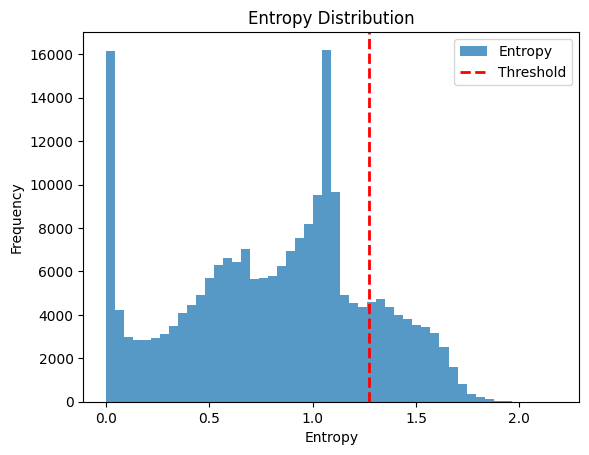

分界值: 1.2740815393175515


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 提取熵值
entropy = result_df['Entropy']

# 计算熵的均值和标准差
entropy_mean = entropy.mean()
entropy_std = entropy.std()
entropy_threshold = entropy_mean + entropy_std

# 绘制熵的分布图
plt.hist(entropy, bins=50, alpha=0.75, label='Entropy')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Entropy Distribution')
plt.axvline(entropy_threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.legend()
plt.show()

# 可信的预测结果
reliable_predictions = result_df[entropy <= entropy_threshold]

# 输出结果
print(f"分界值: {entropy_threshold}")


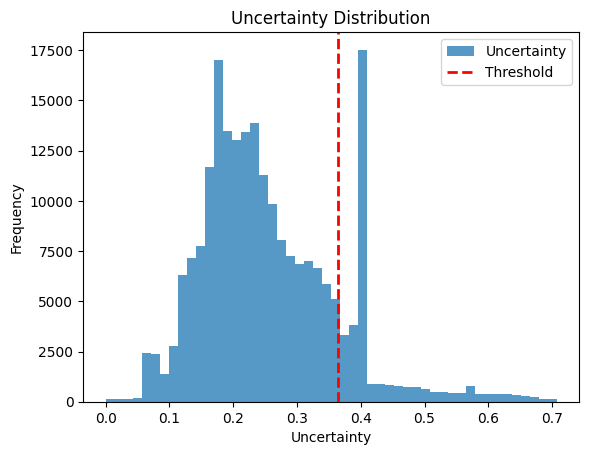

不确定性分界值: 0.3636990232528866


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
uncertainty = result_df['Uncertainty']
# 计算不确定性的均值和标准差
uncertainty_mean = uncertainty.mean()
uncertainty_std = uncertainty.std()
uncertainty_threshold = uncertainty_mean + uncertainty_std

# 绘制不确定性的分布图
plt.hist(uncertainty, bins=50, alpha=0.75, label='Uncertainty')
plt.xlabel('Uncertainty')
plt.ylabel('Frequency')
plt.title('Uncertainty Distribution')
plt.axvline(uncertainty_threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.legend()
plt.show()

# 可信的预测结果
reliable_predictions = result_df[uncertainty <= uncertainty_threshold]

# 输出结果
print(f"不确定性分界值: {uncertainty_threshold}")


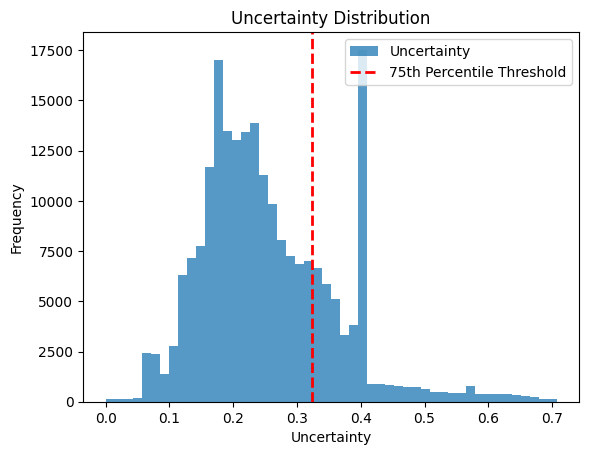

第75百分位数分界值: 0.32344499230384827


In [46]:
# 计算第75百分位数
uncertainty_threshold_75 = np.percentile(uncertainty, 75)

# 绘制不确定性的分布图
plt.hist(uncertainty, bins=50, alpha=0.75, label='Uncertainty')
plt.xlabel('Uncertainty')
plt.ylabel('Frequency')
plt.title('Uncertainty Distribution')
plt.axvline(uncertainty_threshold_75, color='r', linestyle='dashed', linewidth=2, label='75th Percentile Threshold')
plt.legend()
plt.show()

# 可信的预测结果
reliable_predictions_75 = result_df[uncertainty <= uncertainty_threshold_75]

# 输出结果
print(f"第75百分位数分界值: {uncertainty_threshold_75}")